In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import decimal
from scipy.stats import norm

Dans ce notebook, nous évaluerons l'évolution de l'imapct I(T) en fonction du nombre de pas   

In [12]:
# Nous ne fixons plus le nombre de pas P

def W_1(n,P):
    W_1 = np.random.randn(n,P)
    W_1[:, 0]= 0
    return W_1

def gen_X(X_0, W,P, delta, n =5, sigma = 8, lbda = 20):
    A = np.full((n,P),0.0)
    A[:,0] = X_0
    for p in range(1,P):
        A[:,p] =A[:,p-1]*np.exp(-lbda*delta) + X_0*(1- np.exp(-lbda*delta))+np.sqrt(delta)*sigma *W[:,p]
    return A

def gen_X_particulier(X_0,N=1, sigma_2 = 1.689):
    return X_0+np.sqrt(sigma_2)*np.random.normal(size = (N,n))

def insolvance_1(E,v, C, R = 0.05):
    assert len(v) == len(C)
    assert E.shape[0] == len(v) and E.shape[1] == len(v)
    used_up = np.full(len(v),False)
    l=-1
    while True:
        used_up+= v<C
        v = (v - (1-R)*np.sum(E*(used_up), axis = 1))*(v>=C)
        if (l == np.sum(used_up)):
            break
        l = np.sum(used_up)
    return used_up


def I(X, F, E, R = 0.05):
    return np.sum((X + (1-R)*np.sum(E[~F], axis = 0))*(F))

In [13]:
#paramètres du modèles 

N = 100000 
sigma = 8
lbda = 20 
n = 5 


R = 0.05
E = np.array([[0,3,0,0,6],
              [3,0,0,0,0],
              [3,3,0,0,0],
              [2,2,2,0,2],
              [0,2,3,3,0]])

mu = 15. 
c = 10 
X_0 = np.full(n,mu)
C = np.full(n,c)

Première approche : simuler des trajectoires en entier puis estimer l'impact et les probabilités des défaillances associées

In [14]:
#On génère plusieurs trajectoires qui dépendes des pas P

P=200*np.arange(1,25)
P=P.astype(int)
delta = 1 / P
mu = 15
n = 5
num_trials = 10000
X_0=np.full(n*num_trials, mu)
list = [gen_X (X_0, W_1(num_trials*n,p), p, 1/p, n=num_trials*n) for p in P]



Text(0, 0.5, "Probabilité d' au moins une défaillance")

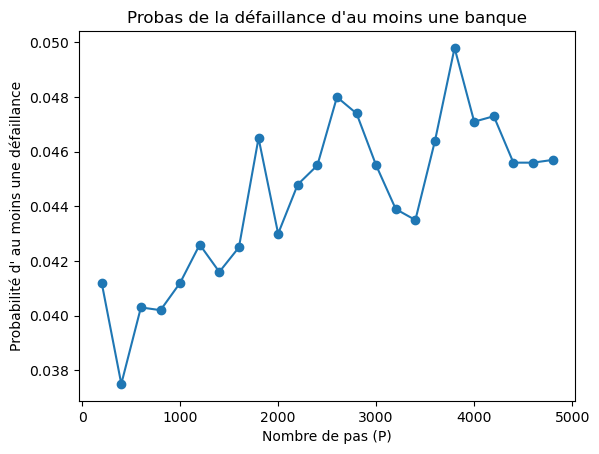

In [15]:

liste_de_matrices = [[A[ i*5:(i+1)*5] for i in range(num_trials)] for A in list ]
def proba_insolvence(i) :
    

    c = 10
    p=P[i]             # nombre de pas
    X_0 = np.array([15] * 5) 
    W = np.random.randn(5, p) 

    T_c = np.array([np.where(np.any(trial < c, axis=0))[0][0] if np.any(np.any(trial < c, axis=0)) else p for trial in liste_de_matrices[i]])

    non_atteint = len(T_c[T_c == p]) / len(T_c)
    return [1 - non_atteint, T_c]

probas = [ ] # probas d'insolvences en fonction des pas
T_c = [ ]
for i in range (len(P)):
    resultats=proba_insolvence(i)
    T_c.append(resultats[1])
    probas.append(resultats[0])
 
 
plt.plot(P, probas, 'o-')
plt.title('Probas de la défaillance d\'au moins une banque')
plt.xlabel('Nombre de pas (P)')
plt.ylabel('Probabilité d\' au moins une défaillance')
        
    
    

Deuxième approche : Nous calculons les impacts et les probabilités de défaillance au fur et à mesure de la simulation des trajectoires. Dès qu'une banque atteint la défaillance, nous ne suivons plus l'évolution de son capital et nous ignorons son influence sur le reste du système


In [36]:
P = 200 * np.arange(1,25)
W_for_all = W_1(n, P[len(P)-1])

def calculate_impact_2(p, delta):
    capital = np.full(n, mu)
    E_n = np.copy(E)
    C_n = np.copy(C)
    W = W_1(n, p)
    impact = 0.0
    for i in range(p):
        capital = capital * np.exp(-lbda * delta) + mu * (1 - np.exp(-lbda * delta)) + np.sqrt(delta) * sigma * W[:, i]
        A = insolvance_1(E_n, capital, C_n)
        
        # Calcul de l'impact à l'instant i
        if (np.sum(A) > 0) : 
            impact += I(capital, A, E_n)
            #capital = capital - np.dot((1 - R),E_n)
            new_impactees = np.where(A == True)[0]
            if len(new_impactees) > 0:
                for j in new_impactees : 
                    capital -= (1-R)*E_n[:,j]
                E_n = np.delete(E_n, new_impactees, axis=0)
                E_n = np.delete(E_n, new_impactees, axis=1)
                W = np.delete(W, new_impactees, axis=0)
                C_n = np.delete(C_n, new_impactees)
                capital = np.delete(capital, new_impactees)

                
    
    return [impact, len(E) - len(E_n)]

In [37]:



total_impact = np.zeros(len(P))
proba_def_total = np.zeros(len(P))
num_simulations = 1000
# Calculons les impacts et des défaillances
for i in range(len(P)):
    resultats = np.array([calculate_impact_2(P[i], 1/P[i]) for _ in range(num_simulations)])
    impacts = np.mean(resultats[:, 0])
    total_impact[i] = impacts
    defaillances = resultats[:, 1]
    proba_def_total[i] = np.mean(defaillances==5)
    print(f"Calcul pour P[{i}] = {P[i]}, Impact moyen = {impacts}, proba de défaillance totale = {proba_def_total[i]}")

    

Calcul pour P[0] = 200, Impact moyen = 1.0484497571232059, proba de défaillance totale = 0.009
Calcul pour P[1] = 400, Impact moyen = 1.224245935649863, proba de défaillance totale = 0.01
Calcul pour P[2] = 600, Impact moyen = 0.7660784801166028, proba de défaillance totale = 0.003
Calcul pour P[3] = 800, Impact moyen = 0.763244261709255, proba de défaillance totale = 0.004
Calcul pour P[4] = 1000, Impact moyen = 1.456044388642072, proba de défaillance totale = 0.01
Calcul pour P[5] = 1200, Impact moyen = 1.5720579689252652, proba de défaillance totale = 0.014
Calcul pour P[6] = 1400, Impact moyen = 1.4092040796563152, proba de défaillance totale = 0.009
Calcul pour P[7] = 1600, Impact moyen = 0.9033941521492413, proba de défaillance totale = 0.005
Calcul pour P[8] = 1800, Impact moyen = 1.0898664810752101, proba de défaillance totale = 0.005
Calcul pour P[9] = 2000, Impact moyen = 0.9163266684631077, proba de défaillance totale = 0.005
Calcul pour P[10] = 2200, Impact moyen = 1.286876

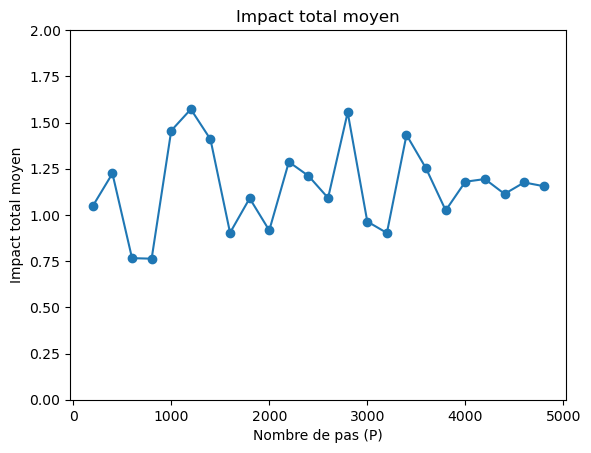

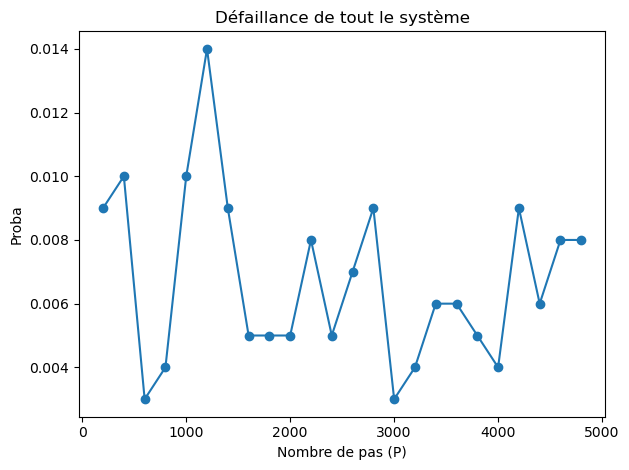

In [42]:


# Tracé de l'impact total moyen en fonction de P
plt.plot(P, total_impact, 'o-')
plt.title('Impact total moyen')
plt.xlabel('Nombre de pas (P)')
plt.ylabel('Impact total moyen')
plt.ylim(0, 2)
plt.show()

# Tracé du nombre de défaillances moyen en fonction de P
plt.plot(P, proba_def_total, 'o-')
plt.title('Défaillance de tout le système')
plt.xlabel('Nombre de pas (P)')
plt.ylabel('Proba')


plt.tight_layout()
plt.show()
